<a href="https://colab.research.google.com/github/shriya67/advanced-pattern-recognition/blob/main/PROJECT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('Agg')  # Using Agg backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Switching backend as per instructions

get_ipython().run_line_magic('matplotlib', 'inline')

import seaborn as sns

# Additional imports for modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Setting seaborn style for plots
sns.set(style='whitegrid')

In [10]:
file_path = '/content/Sleep_health_and_lifestyle_dataset.csv'
df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# Display the first few rows to get a sense of the data
print('DataFrame shape:', df.shape)
df.head()

DataFrame shape: (374, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [11]:
# Data Cleaning and Preprocessing
# Let's inspect data info and check for missing values
print('DataFrame Info:')
print(df.info())

print('\nMissing Values per Column:')
print(df.isnull().sum())

# Since there are no explicit date columns, we skip date type inference.

# For consistency, we can optionally rename columns to snake_case
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
print('\nColumns after renaming:', df.columns.tolist())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB
None



In [12]:
print(df.columns)

Index(['person_id', 'gender', 'age', 'occupation', 'sleep_duration',
       'quality_of_sleep', 'physical_activity_level', 'stress_level',
       'bmi_category', 'blood_pressure', 'heart_rate', 'daily_steps',
       'sleep_disorder'],
      dtype='object')


In [13]:
# Clean up column names in the DataFrame
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Now, the 'numeric_cols' list will work correctly, assuming the column names
# match after cleaning (e.g., 'sleep duration' becomes 'sleep_duration').
numeric_cols = ['person_id', 'age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level', 'stress_level', 'heart_rate', 'daily_steps']
df_numeric = df[numeric_cols]

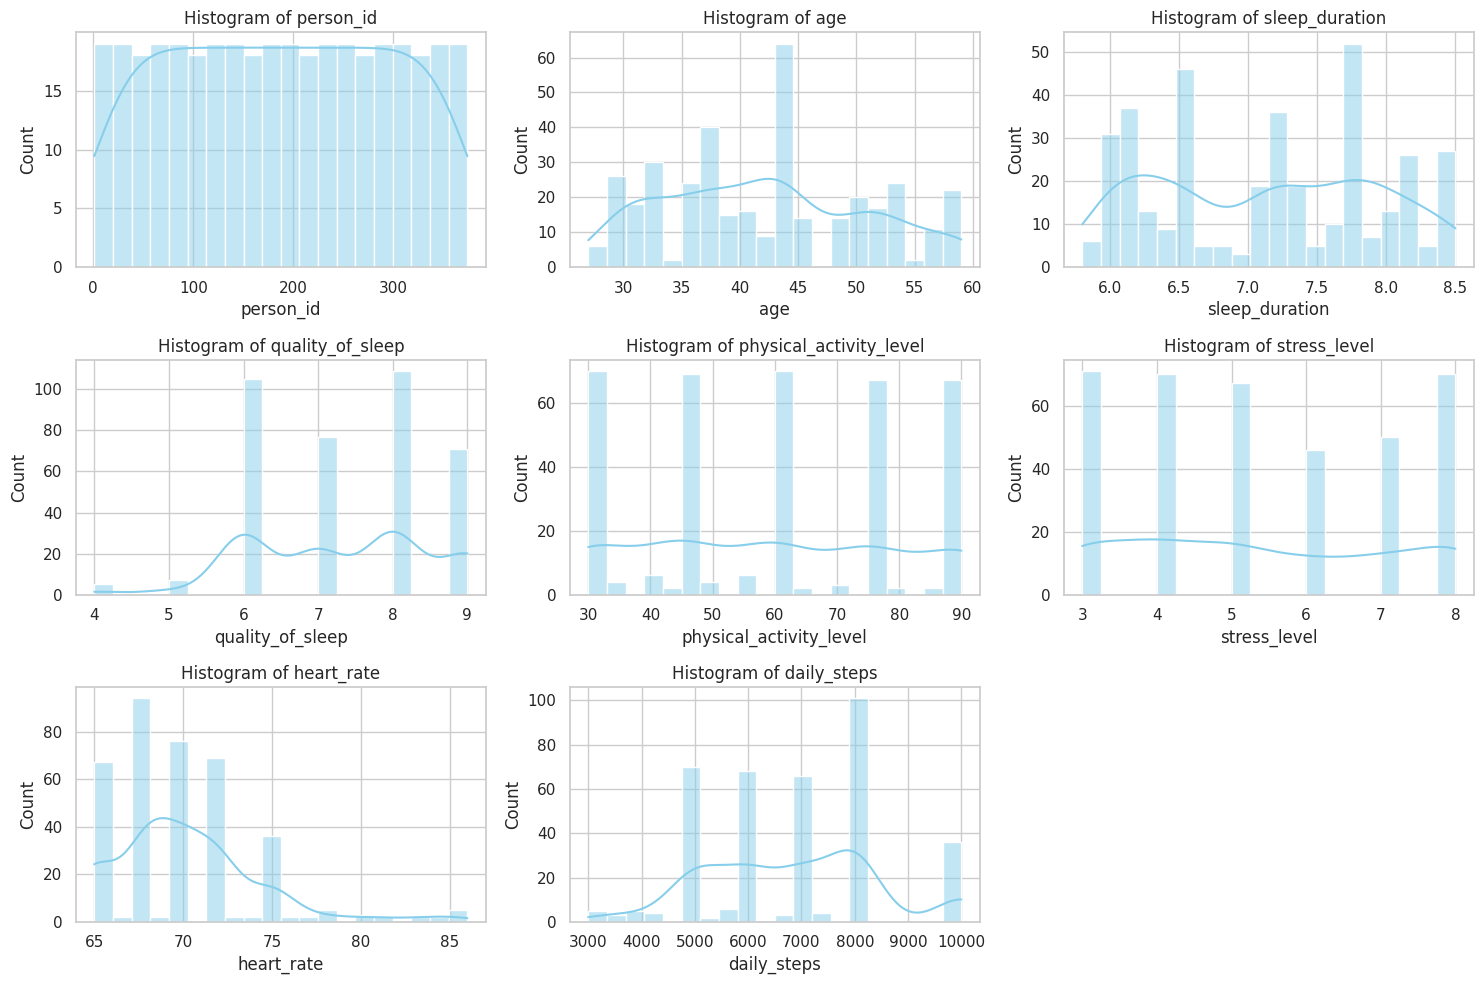

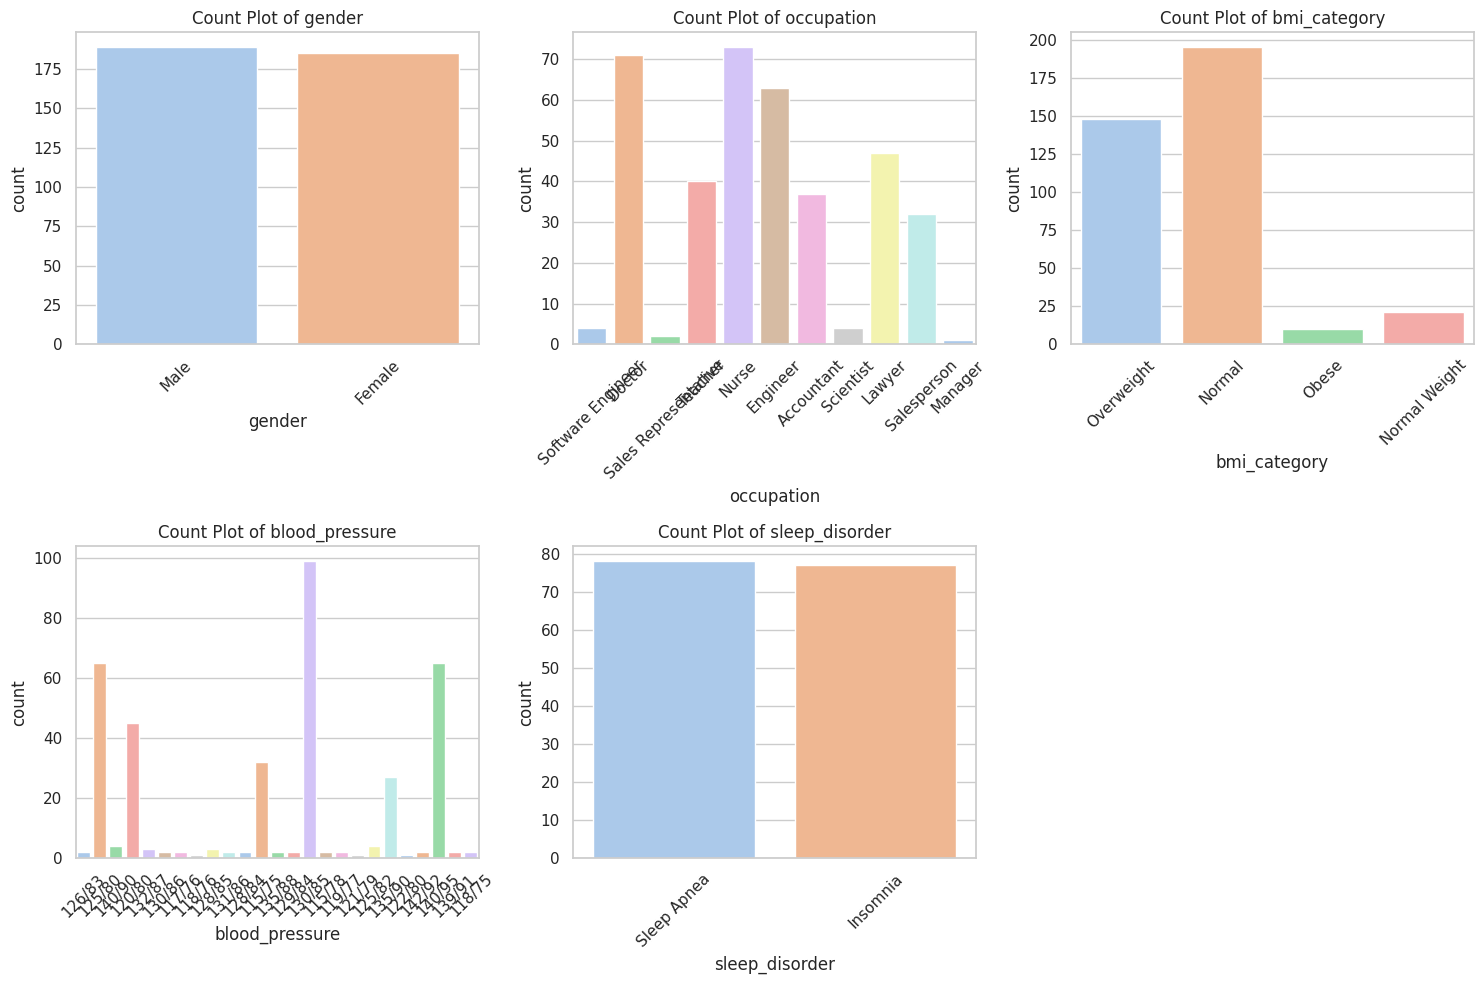

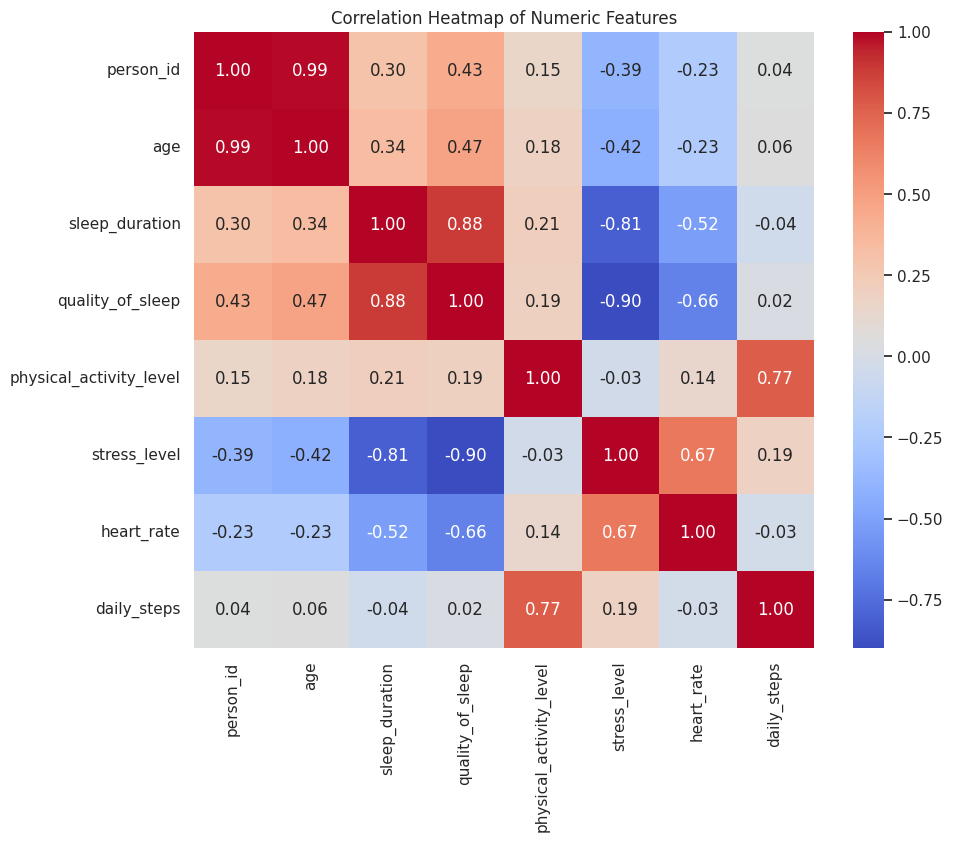

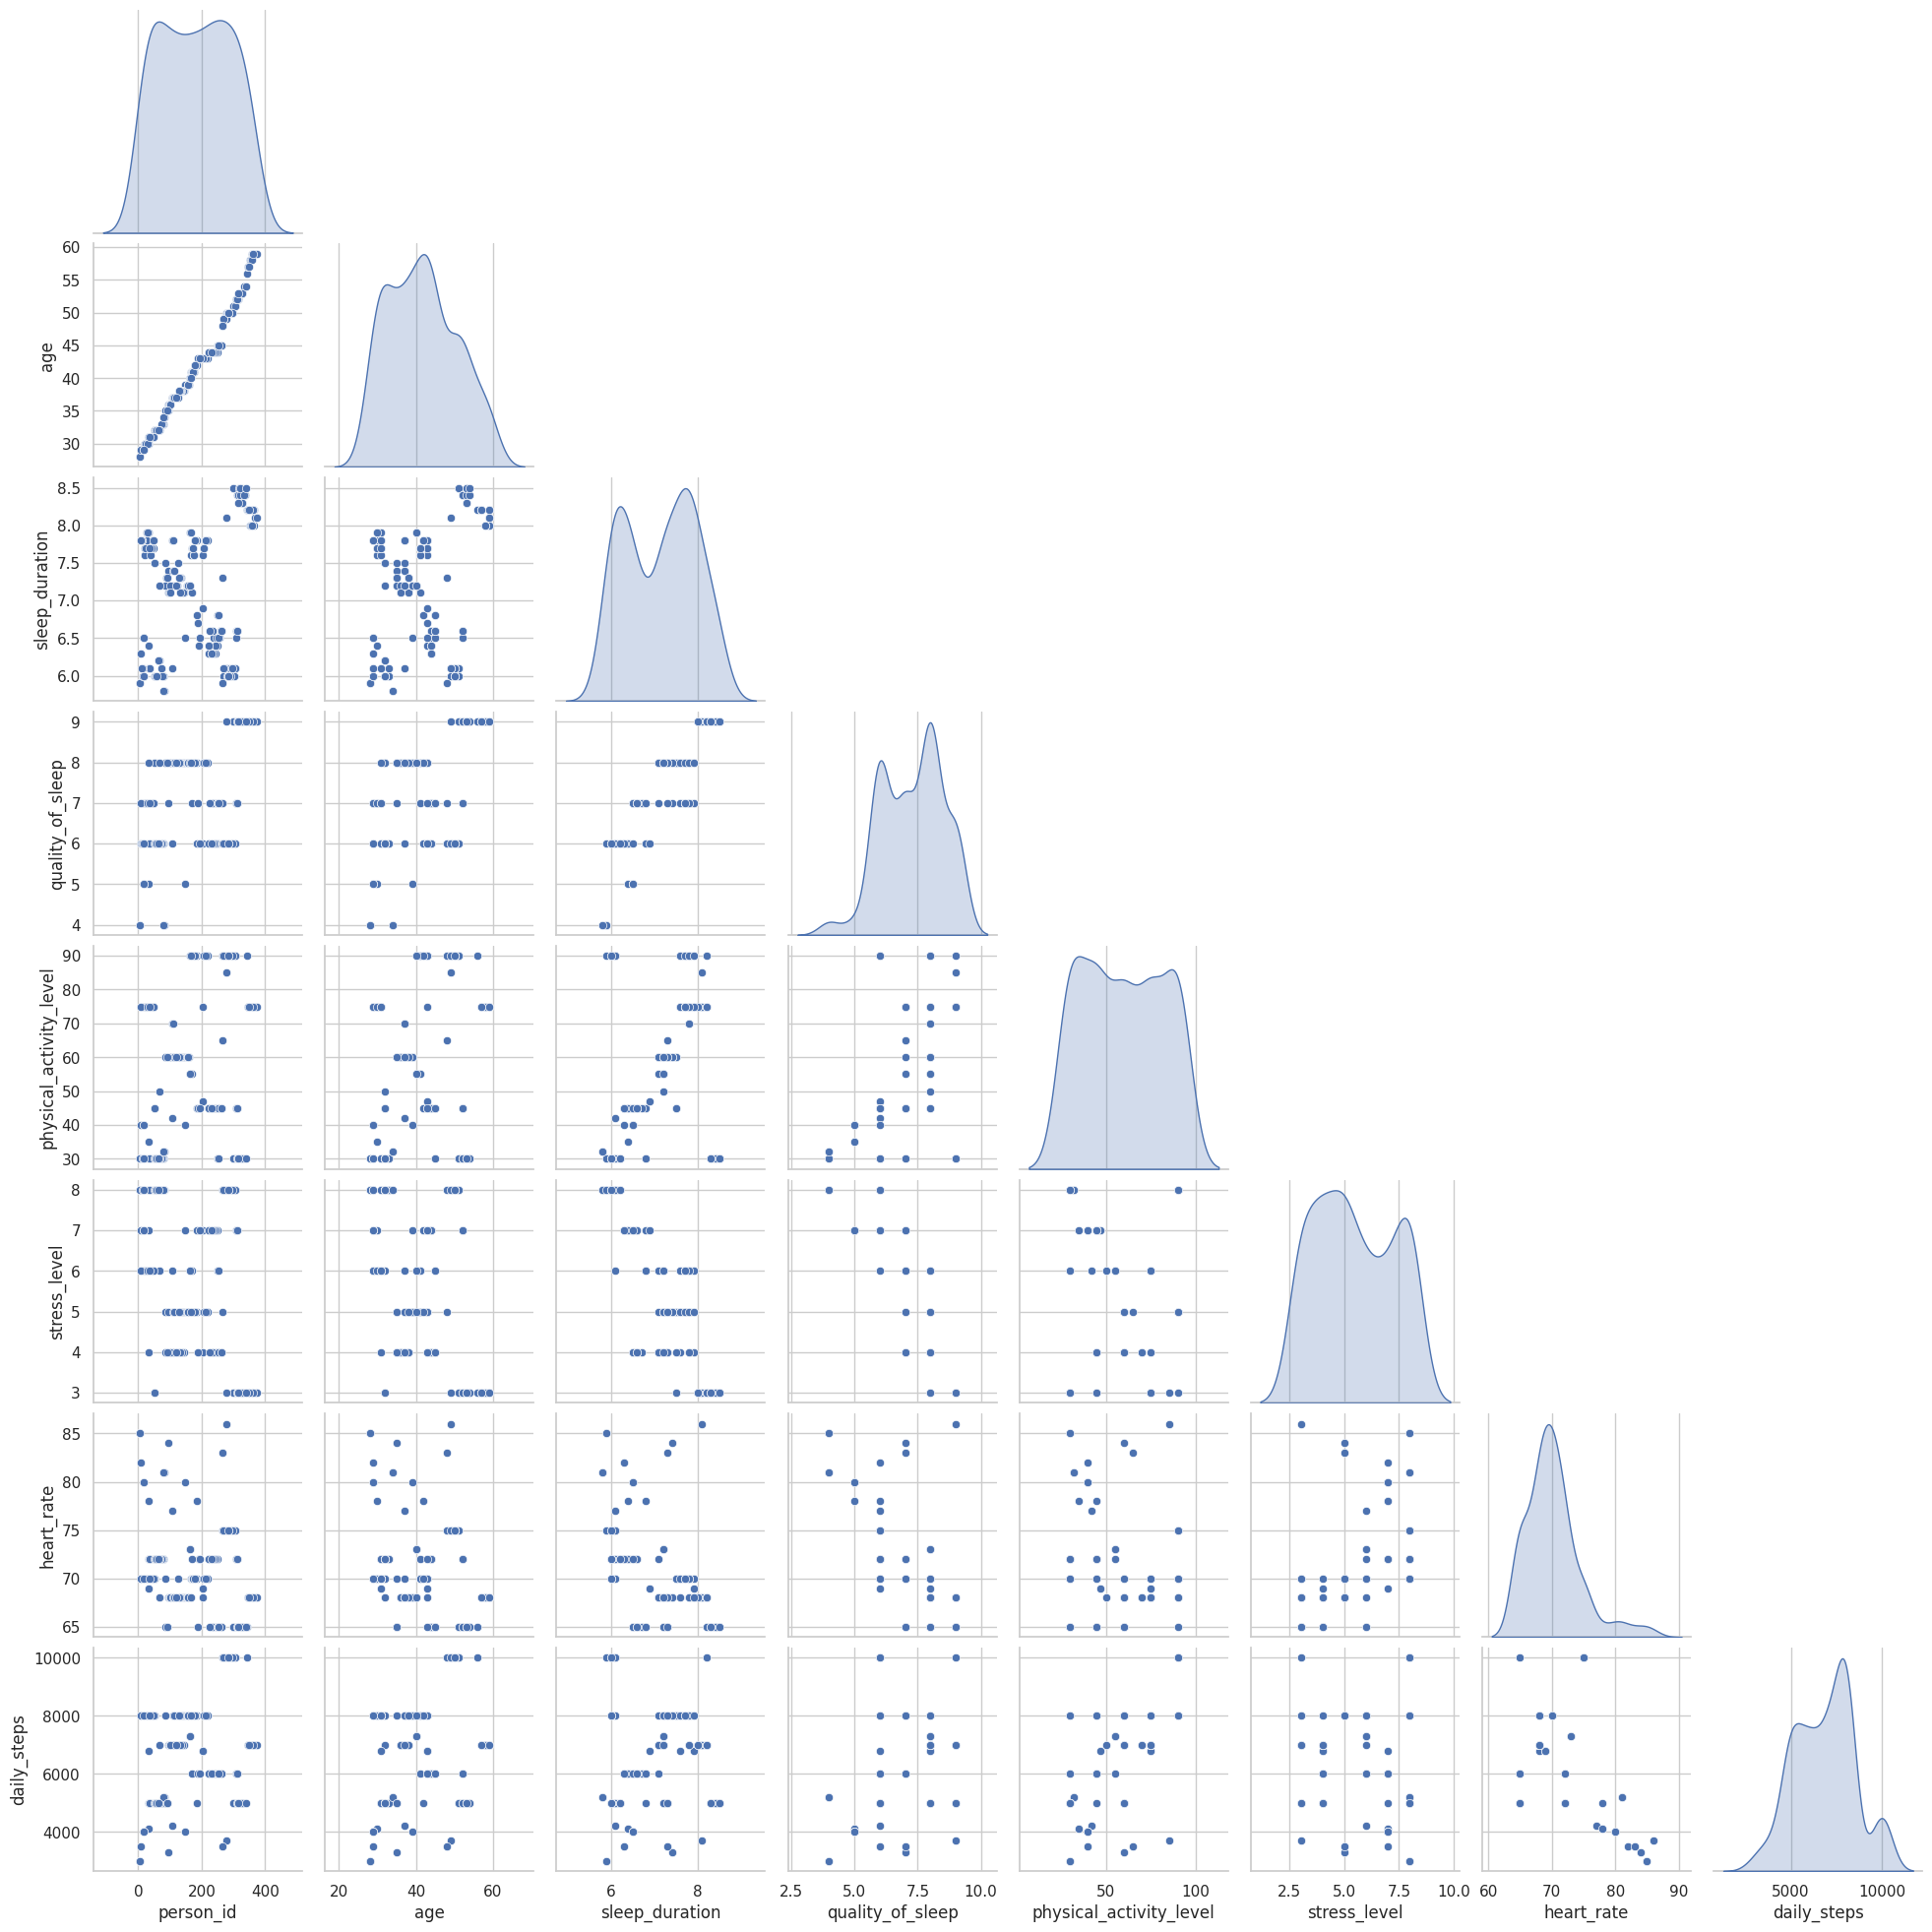

In [14]:
# Exploratory Data Analysis

# Visualizing Numeric Data Distributions using Histograms
numeric_cols = ['person_id', 'age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level', 'stress_level', 'heart_rate', 'daily_steps']
df_numeric = df[numeric_cols]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
plt.show()

# Visualizing Categorical Data using Pie/Count Plots
categorical_cols = ['gender', 'occupation', 'bmi_category', 'blood_pressure', 'sleep_disorder']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
plt.show()

# Correlation Heatmap for Numeric Values (only if at least 4 numeric columns)
if len(numeric_cols) >= 4:
    numeric_df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()

# Pair Plot for numeric features (sampled if needed due to computational cost)
sns.pairplot(df_numeric.sample(min(200, len(df_numeric))), diag_kind='kde', corner=True)
plt.show()

Training set shape: (299, 45)
Test set shape: (75, 45)
Test Accuracy: 0.88


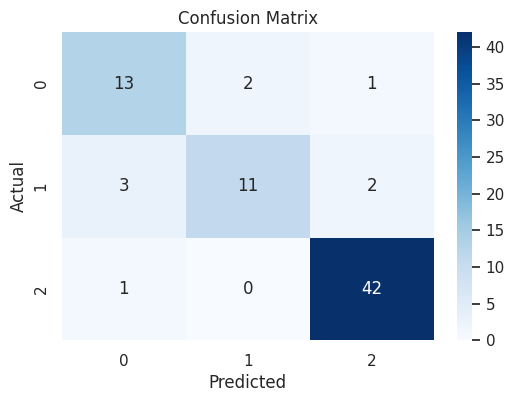

In [15]:
# Preparing the data for prediction
from sklearn.preprocessing import LabelEncoder

# Copy the dataframe to avoid modifying the original
model_df = df.copy()

# Label encode the target 'sleep_disorder'
le = LabelEncoder()
model_df['sleep_disorder_encoded'] = le.fit_transform(model_df['sleep_disorder'])

# Identify features to use (dropping columns that are identifiers or target)
features = ['age', 'sleep_duration', 'quality_of_sleep', 'physical_activity_level', 'stress_level', 'heart_rate', 'daily_steps']

# Additionally include categorical features, which we will one-hot encode
categorical_features = ['gender', 'occupation', 'bmi_category', 'blood_pressure']
model_df = pd.get_dummies(model_df, columns=categorical_features, drop_first=True)

# Update feature list to include new dummy columns
features += [col for col in model_df.columns if any(x in col for x in ['gender_', 'occupation_', 'bmi_category_', 'blood_pressure_'])]

# Define X and y
X = model_df[features]
y = model_df['sleep_disorder_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

# Confusion matrix for further insight
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

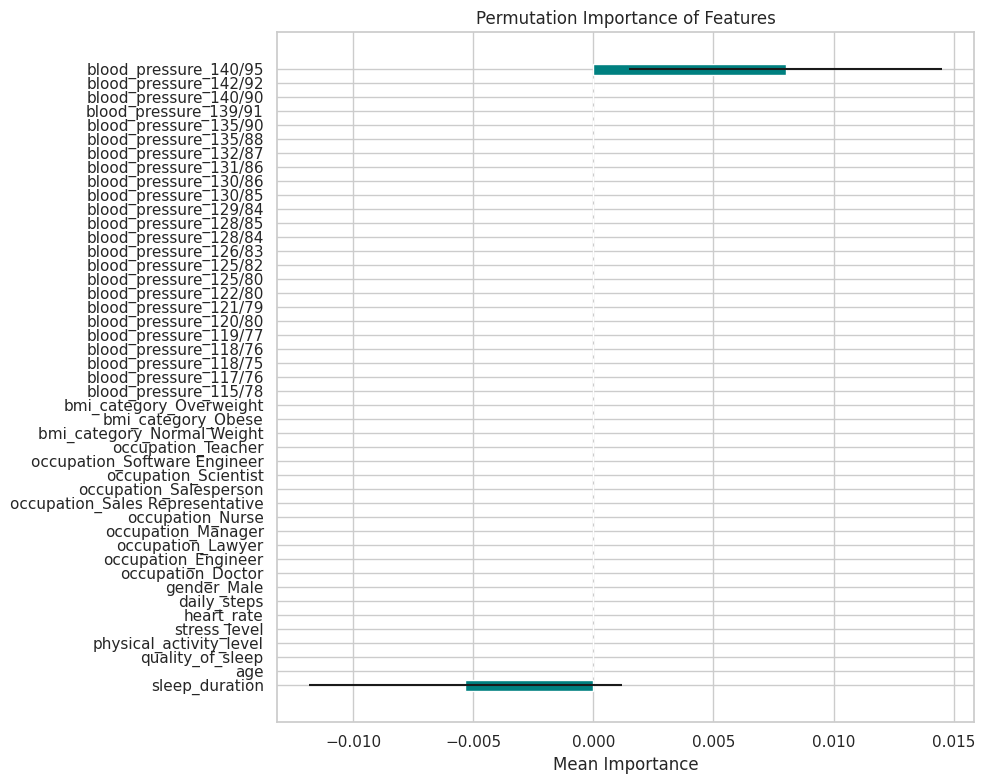

ROC curve is only applicable for binary classification.


In [16]:
# Permutation Importance
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance_mean'], xerr=importance_df['importance_std'], color='teal')
plt.xlabel('Mean Importance')
plt.title('Permutation Importance of Features')
plt.tight_layout()
plt.show()

# Additionally, plotting a ROC curve if binary classification is appropriate
if len(le.classes_) == 2:
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print('ROC curve is only applicable for binary classification.')